In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score

In [2]:
# CCA_top150 connectivity features
CCA_U_path = "/Users/fyzeen/FyzeenLocal/GitHub/DrysdaleReplication/code/03_FeatureSelection/02_rCCA/Results/CCA_top150/CCA_U.csv"
CCA_U = pd.read_csv(CCA_U_path, index_col="Row")

# rCCA_top150 connectivity features
rCCA_U_path = "/Users/fyzeen/FyzeenLocal/GitHub/DrysdaleReplication/code/03_FeatureSelection/02_rCCA/Results/rCCA_top150/rCCA_U.csv"
rCCA_U = pd.read_csv(rCCA_U_path, index_col="Row")

In [3]:
def hierarchical_cluster(data, num_clusters):
    # Perform hierarchical clustering with the optimal number of clusters
    linkage_matrix = linkage(data, method='ward')
    labels = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')
    return labels, linkage_matrix

def plot_labeled_scatter(axis1, axis2, labels):
    plt.scatter(axis1, axis2, c=labels, cmap='viridis')
    plt.xlabel('CV1')
    plt.ylabel('CV2')
    plt.title('Hierarchical Clustering')
    plt.show()

In [4]:
CCA_labels, CCA_linkage_matrix = hierarchical_cluster(CCA_U[["U1", "U2"]].to_numpy(), 3)
rCCA_labels, rCCA_linkage_matrix = hierarchical_cluster(rCCA_U[["Var1","Var2"]].to_numpy(), 4) # ALSO HAS A 2 CLUSTER SOLN

CCA_labels_df = pd.DataFrame(CCA_labels).set_index(CCA_U.index)
rCCA_labels_df = pd.DataFrame(rCCA_labels).set_index(rCCA_U.index)


In [5]:
CCA_Cluster_ARIs = []
rCCA_Cluster_ARIs = []

bootstraps_dir = "/Users/fyzeen/FyzeenLocal/GitHub/DrysdaleReplication/data/local/clusteringBootstraps"
bootstrap_files = os.listdir(bootstraps_dir)

for bootstrap_file in bootstrap_files:
    bootstrap = pd.read_csv(os.path.join(bootstraps_dir, bootstrap_file), index_col="Row")
    
    # Getting the labels for the subjects that were included in this bootstrap
    subset_CCA_labels = CCA_labels_df.loc[bootstrap.index].to_numpy().T[0]
    subset_rCCA_labels = rCCA_labels_df.loc[bootstrap.index].to_numpy().T[0]
    
    bootstrap_CCA_labels, boootstrap_CCA_linkage_matrix = hierarchical_cluster(bootstrap[["CCA_U1","CCA_U2"]].to_numpy(), 3)
    
    bootstrap_rCCA_labels, boootstrap_rCCA_linkage_matrix = hierarchical_cluster(bootstrap[["rCCA_U1","rCCA_U2"]].to_numpy(), 4)
    
    CCA_Cluster_ARIs.append(adjusted_rand_score(subset_CCA_labels, bootstrap_CCA_labels))
    rCCA_Cluster_ARIs.append(adjusted_rand_score(subset_rCCA_labels, bootstrap_rCCA_labels))

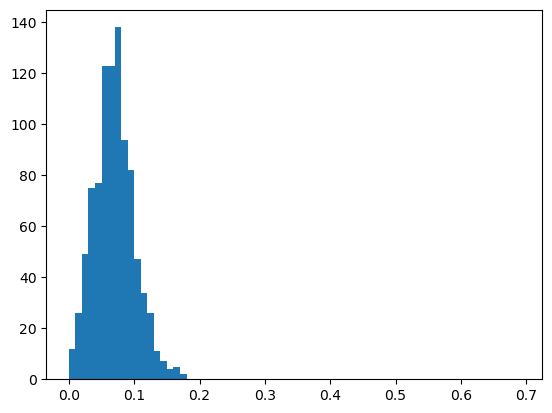

In [8]:
plt.hist(np.array(CCA_Cluster_ARIs), np.arange(0,0.7, 0.01))
plt.show()

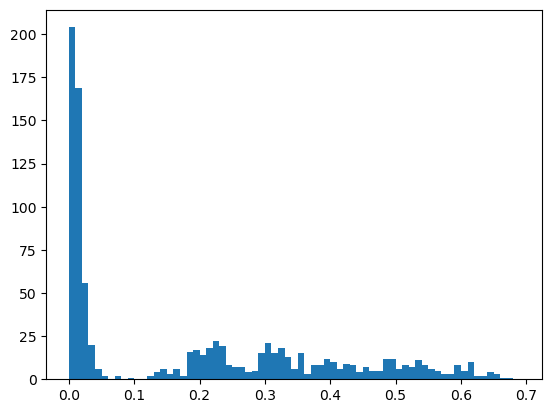

In [9]:
plt.hist(np.array(rCCA_Cluster_ARIs), np.arange(0,0.7, 0.01))
plt.show()

In [37]:
# Analyze the correlation between CCA components (U1, U2) in each bootstrap to CCA components from the whole-data CCA
U1_U1Corr = []
U1_U2Corr = []
U2_U1Corr = []
U2_U2Corr = []

rU1_U1Corr = []
rU1_U2Corr = []
rU2_U1Corr = []
rU2_U2Corr = []



bootstraps_dir = "/Users/fyzeen/FyzeenLocal/GitHub/DrysdaleReplication/data/local/clusteringBootstraps"
bootstrap_files = os.listdir(bootstraps_dir)

for bootstrap_file in bootstrap_files:
    bootstrap = pd.read_csv(os.path.join(bootstraps_dir, bootstrap_file), index_col="Row")
    
    # Compute Correlations between canonical covariates
    U1_U1 = np.corrcoef(bootstrap["CCA_U1"], CCA_U.loc[bootstrap.index]["U1"])[0,1]
    rU1_U1 =np.corrcoef(bootstrap["rCCA_U1"], rCCA_U.loc[bootstrap.index]["Var1"])[0,1]
    U1_U1Corr.append(U1_U1)
    rU1_U1Corr.append(rU1_U1)
    
    U1_U2 = np.corrcoef(bootstrap["CCA_U1"], CCA_U.loc[bootstrap.index]["U2"])[0,1]
    rU1_U2 =np.corrcoef(bootstrap["rCCA_U1"], rCCA_U.loc[bootstrap.index]["Var2"])[0,1]
    U1_U2Corr.append(U1_U2)
    rU1_U2Corr.append(rU1_U2)
    
    U2_U1 = np.corrcoef(bootstrap["CCA_U2"], CCA_U.loc[bootstrap.index]["U1"])[0,1]
    rU2_U1 =np.corrcoef(bootstrap["rCCA_U2"], rCCA_U.loc[bootstrap.index]["Var1"])[0,1]
    U2_U1Corr.append(U2_U1)
    rU2_U1Corr.append(rU2_U1)
    
    
    U2_U2 = np.corrcoef(bootstrap["CCA_U2"], CCA_U.loc[bootstrap.index]["U2"])[0,1]
    rU2_U2 =np.corrcoef(bootstrap["rCCA_U2"], rCCA_U.loc[bootstrap.index]["Var2"])[0,1]
    U2_U2Corr.append(U2_U2)
    rU2_U2Corr.append(rU2_U2)
    

maxCorrs = []
RegmaxCorrs = []
for i in range(len(U1_U1Corr)):
    maxCorr = max([U1_U1Corr[i], U1_U2Corr[i], U2_U1Corr[i], U2_U2Corr[i]])
    maxCorrs.append(maxCorr)
    
    
    RegmaxCorr = max([rU1_U1Corr[i], rU1_U2Corr[i], rU2_U1Corr[i], rU2_U2Corr[i]])
    RegmaxCorrs.append(RegmaxCorr)

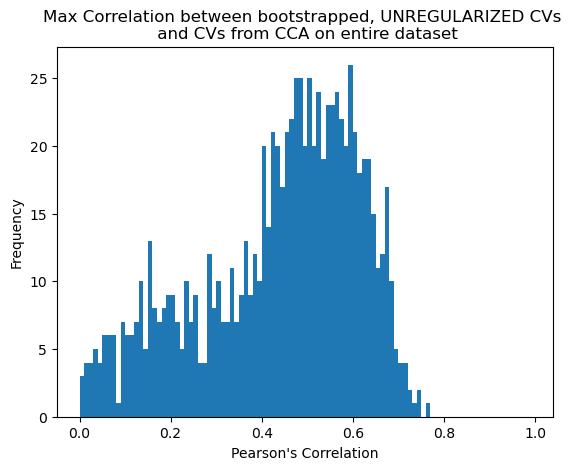

In [59]:
plt.hist(np.array(maxCorrs), np.arange(0, 1, 0.01))
plt.title("Max Correlation between bootstrapped, UNREGULARIZED CVs \n and CVs from CCA on entire dataset")
plt.ylabel("Frequency")
plt.xlabel("Pearson's Correlation")
plt.show()

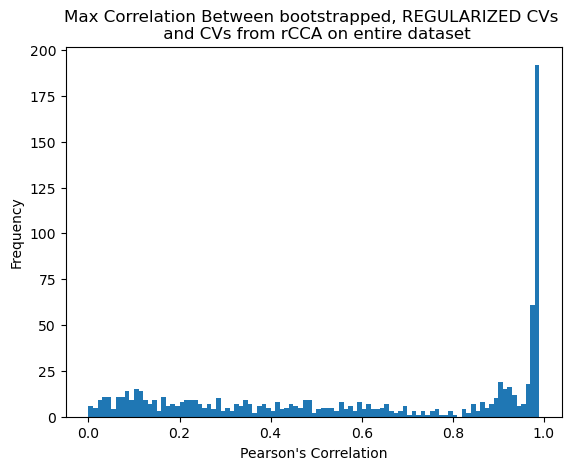

In [57]:
plt.hist(np.array(RegmaxCorrs), np.arange(0, 1, 0.01))
plt.title("Max Correlation Between bootstrapped, REGULARIZED CVs \n and CVs from rCCA on entire dataset")
plt.ylabel("Frequency")
plt.xlabel("Pearson's Correlation")
plt.show()